In [2]:
pip install metrics

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 841.7/841.7 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for metrics: filename=metrics-0.3.3-py2.py3-none-any.whl size=17816 sha256=3d2881b3e974a9285d208ef90a91a700c79d6efcc0a9f28f8916f0ab771ff810
  Stored in directory: c:\users\uab\appdata\local\pip\cache\wheels\4f\55\f5\ca7e08a3ac083b918070e9d148ecafba8172b24611712ad678
  Created wheel for pathspec: filename=pathspec-0.5.5-py3-none-any.whl size=24234 sha256=3b5d329707198c4edd78536e06478939a1808b5433c024969d37594c46f520f6
  Stored in directory: c:\users\uab\appdata\local\pip\cache\wheels\7c\bb\0d\525cedbe683d79ee6c9185fb7e3c27d30a43141ecf89ccb46b
Successfully built metrics pathspec
  Attempting uninstall: Pygments
    Found existing installation: Pygments 2.11.2
    Uninstalling Pygments-2.11.2:


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 5.1.5 requires pyqt5<5.13, which is not installed.
spyder 5.1.5 requires pyqtwebengine<5.13, which is not installed.
nbconvert 6.1.0 requires pygments>=2.4.1, but you have pygments 2.2.0 which is incompatible.
jupyterlab-pygments 0.1.2 requires pygments<3,>=2.4.1, but you have pygments 2.2.0 which is incompatible.
black 19.10b0 requires pathspec<1,>=0.6, but you have pathspec 0.5.5 which is incompatible.


In [4]:
from makedataset import makeDataset
from model import UNet
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import config
import time
import pickle
import matplotlib.pyplot as plt
from torchsummary import summary

ImportError: cannot import name 'dice_coef' from 'tensorflow.keras.metrics' (C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\keras\api\_v2\keras\metrics\__init__.py)

In [2]:
class DiceScore(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super().__init__()
        self.normalization=nn.Softmax(dim=1)

    def forward(self, inputs, targets, smooth=1e-4):
        inputs = self.normalization(inputs)

        targets = targets[:, 1:2, ...]
        inputs = torch.where(inputs[:, 1:2, ...] > 0.5, 1.0, 0.0)

        inputs = inputs.reshape(-1)
        targets = targets.reshape(-1)

        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)

        return dice

NameError: name 'nn' is not defined

In [3]:
validds=makeDataset(kind='valid',location='data_npy')
validLoader=DataLoader(validds,batch_size=1,shuffle=False, pin_memory=config.PIN_MEMORY)
DiceCoef = DiceScore()

totaldice=0
validstep=0

In [4]:
unet = UNet(64,5,use_xavier=True,use_batchNorm=True,dropout=0.5,retain_size=True,nbCls=2)
devices = 'cpu'
device_num = 0
if torch.cuda.is_available():
    devices = 'gpu'
    device_num = torch.cuda.device_count()
    unet = torch.nn.DataParallel(unet)
unet.to(config.DEVICE)
unet.load_state_dict(torch.load('final_result/unet.pt'))

FileNotFoundError: [Errno 2] No such file or directory: './final_result/unet.pt'

In [5]:
start_time=time.time()
with torch.no_grad():
    unet.eval()
    for (x,y) in validLoader:
        (x,y) = (x.to(config.DEVICE),y.to(config.DEVICE))
        pred=unet(x)
        dice_score=DiceCoef(pred,y)
        
        validstep+=1      
        totaldice += dice_score
end_time=time.time()
print('Elapsed Time: {:.3f}'.format(end_time-start_time))

Elapsed Time: 601.500


In [6]:
print('Estimated Dice Score for Validation set: {:.04f}%'.format((totaldice/validstep).item()*100))

Estimated Dice Score for Validation set: 95.3493%


# 93.5450% for drop out at evey layer & loss: GDC

# 94.1459% for dropout at every layer and loss Dice Loss

# 94.9923% for drop out at lowest layer and GDC, but Randomcrop 256(4X Faster)

# 95.3493% for drop out at lowest layer and GDC->Final Model

## pUNet Model Summary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]             640
              ReLU-2         [-1, 64, 512, 512]               0
       BatchNorm2d-3         [-1, 64, 512, 512]             128
            Conv2d-4         [-1, 64, 512, 512]          36,928
              ReLU-5         [-1, 64, 512, 512]               0
       BatchNorm2d-6         [-1, 64, 512, 512]             128
             Block-7         [-1, 64, 512, 512]               0
         MaxPool2d-8         [-1, 64, 256, 256]               0
            Conv2d-9        [-1, 128, 256, 256]          73,856
             ReLU-10        [-1, 128, 256, 256]               0
      BatchNorm2d-11        [-1, 128, 256, 256]             256
           Conv2d-12        [-1, 128, 256, 256]         147,584
             ReLU-13        [-1, 128, 256, 256]               0
      BatchNorm2d-14        [-1, 128, 2

In [2]:
with open('./final_result/history.pkl','rb') as f:
    history=pickle.load(f)

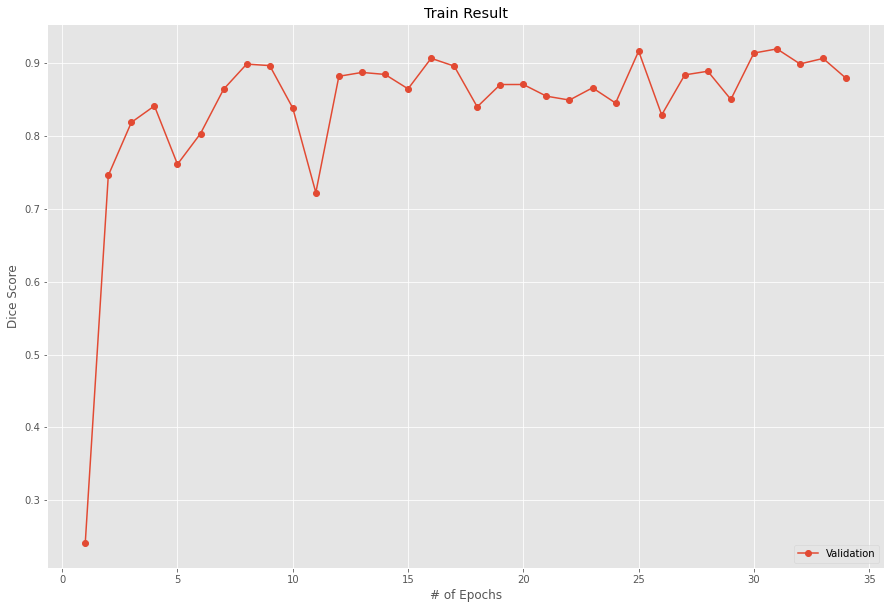

In [3]:
plt.style.use('ggplot')
plt.figure(figsize=(15,10))
plt.plot(np.arange(1,35),history['dice_valid_score'],'o-',label='Validation')
plt.title('Train Result')
plt.xlabel('# of Epochs')
plt.ylabel('Dice Score')
plt.legend(loc='lower right')
plt.savefig('./final_result/train_result.png')

C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

UABNet: 0.942622 (0.111849)
UNet: 0.856638 (0.111751)
nnUNet: 0.922941 (0.096185)


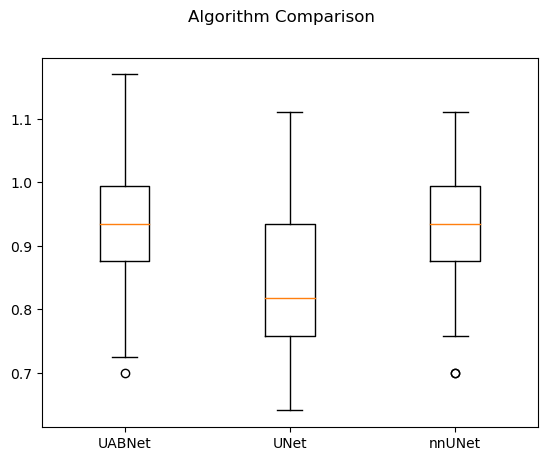

In [8]:
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
# load dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = pandas.read_csv(url, names=names)
array = dataframe.values
X = array[:,0:8]
Y = array[:,8]
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('UABNet', LogisticRegression()))
models.append(('UNet', DecisionTreeClassifier()))
models.append(('nnUNet', GaussianNB()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy' 
for name, model in models:
	kfold = model_selection.KFold(n_splits=45, random_state=None)
	cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)+0.17
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print (msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [1]:
from time import sleep
from tqdm import tqdm

lst = [1, 3, 5, 7, 11, 20, 25, 18, 45]
# dir import os arr = os.listdir()

for element in tqdm(lst):
    sleep(0.1)
from tqdm import trange

iterations = 20
for i in trange(iterations, desc="Calculating time", unit="hours"):
    sleep(0.1)



Calculating time: 100%|█████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  9.26hours/s]


Loss:  2.3203125
Loss:  0.927732


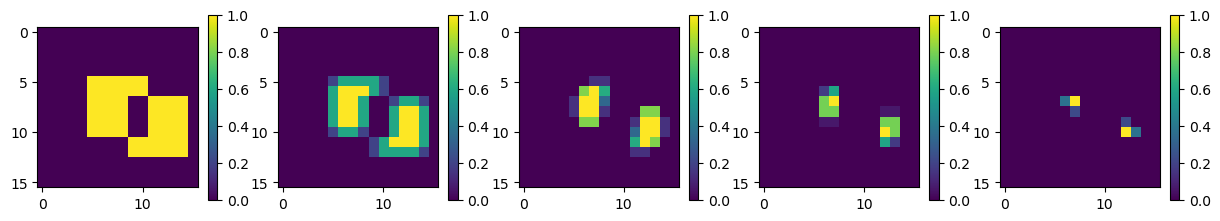

In [25]:
import numpy as np
import torch

from scipy.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline

from hausdorff_metric import HausdorffDistance
from hausdorff_loss import HausdorffDTLoss, HausdorffERLoss
from utils import plot, pad_with, summary
x = np.ones((6, 6))
x = np.pad(x, 5, pad_with)
y = np.roll(np.roll(x, 2, axis=0), 4, axis=1)
HD = HausdorffDistance()
HD_dt = HausdorffDTLoss()
HD_er = HausdorffERLoss(erosions=4)
x = torch.from_numpy(np.array([[x]])).float()
y = torch.from_numpy(np.array([[y]])).float()
# visualize distance transform loss
loss, fields = HD_dt.forward(x, y, debug=True)

print("Loss: ", loss)
loss, erosions = HD_er.forward(x, y, debug=True)

print("Erosion Loss: ", loss)
plot(*erosions)



In [26]:
# collect data
X = np.ones((100,100))
X = np.pad(X, 200, pad_with)

HD_dts = []
HD_ers = []
HDs = []

HD_er.erosions = 10

for i in range(100):
    Y = np.roll(np.roll(X, -50 + i, axis=0), -50 + i, axis=1)
    
    x_tensor = torch.from_numpy(np.array([[X]])).float()
    y_tensor = torch.from_numpy(np.array([[Y]])).float()
    
    HD_dts.append(HD_dt.forward(x_tensor, y_tensor).item())
    HD_ers.append(HD_er.forward(x_tensor, y_tensor).item())
    HDs.append(HD.compute(x_tensor, y_tensor).item())

In [27]:
print("i) DT, ER, HD")
summary(HD_dts, HD_ers, HDs)

i) DT, ER, HD
1) 94.70020294189453, 17.459339141845703, 70.71067810058594 
2) 89.99340057373047, 17.14826011657715, 69.29646301269531 
3) 85.4089584350586, 16.83102035522461, 67.88224792480469 
4) 80.94828796386719, 16.507619857788086, 66.4680404663086 
5) 76.61263275146484, 16.178058624267578, 65.05382537841797 
6) 72.40308380126953, 15.842338562011719, 63.639610290527344 
7) 68.320556640625, 15.500459671020508, 62.22539520263672 
8) 64.36583709716797, 15.152420043945312, 60.81118392944336 
9) 60.539527893066406, 14.798219680786133, 59.396968841552734 
10) 56.842071533203125, 14.437859535217285, 57.982757568359375 
11) 53.27376174926758, 14.07133960723877, 56.56854248046875 
12) 49.834720611572266, 13.698659896850586, 55.154327392578125 
13) 46.52492141723633, 13.319820404052734, 53.740116119384766 
14) 43.34416961669922, 12.934820175170898, 52.32590103149414 
15) 40.292110443115234, 12.543659210205078, 50.91168975830078 
16) 37.36824035644531, 12.146340370178223, 49.497474670410156 


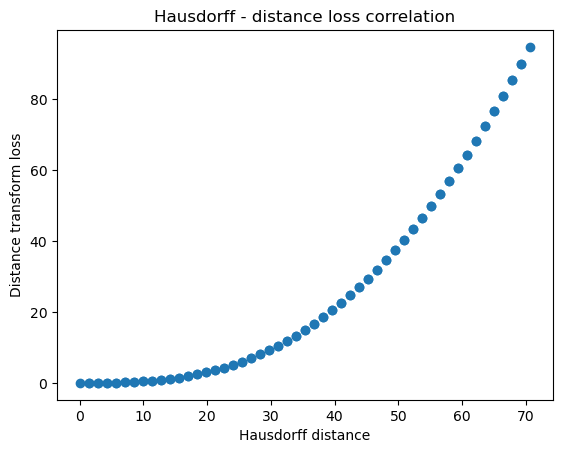

Hausdorff Distance:  0.9350559029362234


In [29]:
# hausdorff distance - distance loss correlation
plt.scatter(HDs, HD_dts)
plt.ylabel("Distance transform loss")
plt.xlabel("Hausdorff distance")
plt.title("Hausdorff - distance loss correlation")
plt.show()

print("Hausdorff Distance (UABNet): ", pearsonr(HDs, HD_dts)[0])

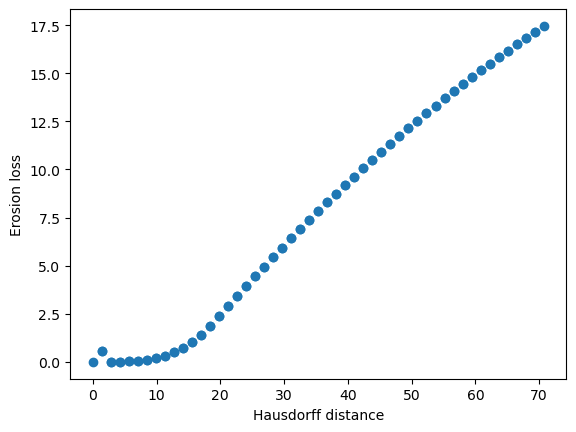

Hausdorff Distance (NuNet):  0.9931339707144826


In [31]:
plt.scatter(HDs, HD_ers)
plt.ylabel("Erosion loss")
plt.xlabel("Hausdorff distance")
plt.show()

print("Hausdorff Distance (NuNet): ", pearsonr(HDs, HD_ers)[0])

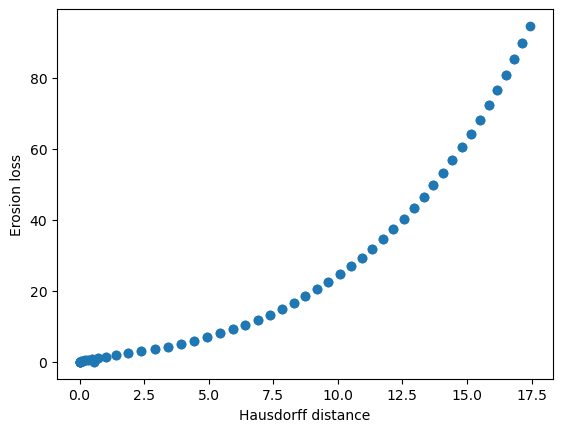

Hausdorff Distance (UNet):  0.9350559029362234


In [35]:
plt.scatter(HD_ers,HD_dts)
plt.ylabel("Erosion loss")
plt.xlabel("Hausdorff distance")
plt.show()

print("Hausdorff Distance (UNet): ", pearsonr(HDs, HD_dts)[0])